# Домашнее задание №2 - Линейные модели. Градиентный спуск

В этом домашнем задании мы с вами научимся обучать линейные модели регрессии и классификации при помощи очень мощного, но в то же время довольно понятного алгоритма, который называется **градиетный спуск**. Помимо линейных моделей он используется и для обучения самых сложных нейронных сетей! Также мы потренируемся применять готовые реализации линейных моделей для задач регрессии и бинарной классификации.

In [471]:
import re

import numpy as np
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import random
import pandas as pd

import statsmodels.api as sm
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
from sklearn.exceptions import NotFittedError
from sklearn.linear_model import (LinearRegression,
                                  LogisticRegression)
from sklearn.datasets import fetch_california_housing
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.datasets import make_classification
from sklearn.metrics import (r2_score,
                             mean_squared_error,
                             mean_absolute_error)
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import RocCurveDisplay, roc_auc_score, roc_curve, auc

In [291]:
plt.rcParams["figure.figsize"] = 12, 9
sns.set_style("whitegrid")

SEED = 111
random.seed(SEED)
np.random.seed(SEED)

#### Маленькое теоретическое отступление

Основное свойство антиградиента (-1 * градиент) &ndash; он указывает в сторону наискорейшего убывания функции в данной точке. Соответственно, будет логично стартовать из некоторой точки, сдвинуться в сторону антиградиента, пересчитать антиградиент и снова сдвинуться в его сторону и т.д. Запишем это более формально.

Пусть $w_0$ &ndash; начальный набор параметров (коэффициентов линейной модели) ((например, нулевой или сгенерированный из некоторого, случайного распределения)). Тогда обычный градиентный спуск состоит в повторении следующих шагов до сходимости:


$$
    w_{k + 1} = w_{k} - \eta \nabla_{w} Q(w_{k}),
$$

где $\nabla_{w} Q(w_{k})$ &ndash; градиент функции потерь в точке $w_k$, а $\eta$ &ndash; скорость обучения (learning rate).

Градиентный спуск обычно останавливают, когда прошло заданное максимальное количество итераций или когда графиент близок к нулю (т.е. наши параметры практически не меняются). Для реализации второго варианта считают норму градиента (по сути длину вектора). Это можно сделать несколькими способами:

$$
l1_{norm} = \sum{|w_i|}
$$

$$
l2_{norm} = \sum{(w_i)^{2}}
$$

Попробуем разобраться на простом примере. Рассмотрим функцию от двух переменных:
$f(x, y) = \sin^2 x + \sin^2 y$

In [292]:
def f(w):
    """
    :param w: np.array(np.float) вектор из 2-х элементов
    :return: np.float
    """
    
    return np.sum(np.sin(w)**2)

Обратите внимание, что $x$ - numpy-array вектор длины 2.

***Reminder:***  
Что мы хотим? Мы хотим найти минимум этой функции (в машинном обучении мы обычно хотим найти минимум **функции потерь**, например, MSE), а точнее найти $w_1$ и $w_2$ такие, что при них значение $f(w_1, w_2)$ минимально, то есть *точку экстремума*.  
  
Как мы будем искать эту точку? Используем методы оптимизации (в нашем случае - *минимизации*). Одним из таких методов и является **градиентный спуск**.

### Задание 1. Градиентный спуск для функции $f$ (1 балл)

Реализуйте функцию, которая будет осуществлять градиентный спуск для функции $f$:

*Примечание:* Вам нужно посчитать частные производные именно **аналитически** и **переписать их в код**, а не считать производные численно (через отношение приращения функции к приращению аргумента) -- в этих двух случаях могут различаться ответы, поэтому будьте внимательны.

In [293]:
def grad_f(w): 
    """
    Градиент функциии f, определенной выше.
        :param w: np.array[2]: float вектор из 2-х элементов
        :return: np.array[2]: float вектор из 2-х элементов
    """
    
    """
    YOUR CODE IS HERE
    """
    derivative = np.sin(2 * w)
    return derivative

Проверим, что градиент принимает вектор из двух чисел и выдает на этой точке верное значение

In [294]:
assert np.allclose(grad_f(np.array([1, 2])), 
                   np.array([0.90929743, -0.7568025])), "Что-то не так!"

In [295]:
def grad_descent_2d(f, grad_f, lr, num_iter=100, x0=None):
    """
    Функция, которая реализует градиентный спуск в минимум для функции f от двух переменных. 
        :param f: скалярная функция двух переменных
        :param grad_f: функция, возвращающая градиент функции f (устроена как реализованная вами выше grad_f)
        :param lr: learning rate алгоритма
        :param num_iter: количество итераций градиентного спуска
        :return: np.array[num_iter, 2] пар вида (x, f(x))
    """
    
    w0 = np.random.random(2)

    # будем сохранять значения аргументов и значений функции 
    # в процессе град. спуска в переменную history
    history = []

    # итерация цикла == шаг градиентнго спуска
    curr_w = w0.copy()
    for iter_num in range(num_iter):
        entry = np.hstack((curr_w, f(curr_w)))
        history.append(entry)
    
        curr_w -= lr * grad_f(curr_w) #  YOUR CODE. Не забудьте про lr!

    return np.vstack(history)

Визуализируем точки градиентного спуска на 3D-графике нашей функции. Звездочками будут обозначены точки (тройки $w_1, w_2, f(w_1, w_2)$), по которым Ваш алгоритм градиентного спуска двигался к минимуму (Для того, чтобы написовать этот график, мы и сохраняли значения $cur\_w_1, cur\_w_2, f(cur\_w_1, cur\_w_2)$ в `steps` в процессе спуска).

Если у Вас правильно написана функция `grad_descent_2d`, то звездочки на картинке должны сходиться к одной из точек минимума функции. Вы можете менять начальные приближения алгоритма, значения `lr` и `num_iter` и получать разные результаты.

In [296]:
def gradient_desc_vis(f, grad_f, lr=0.1, num_iter=20):
    steps = grad_descent_2d(f, grad_f, lr=lr, num_iter=num_iter)
    
    X, Y = np.meshgrid(np.linspace(-3, 3, 100), np.linspace(-3, 3, 100))

    fig = plt.figure(figsize=(16, 10))
    ax = fig.add_subplot(projection="3d")

    zs = np.array([f(np.array([x,y]))
                  for x, y in zip(np.ravel(X), np.ravel(Y))])
    Z = zs.reshape(X.shape)


    ax.plot_surface(X, Y, Z, cmap=cm.coolwarm, zorder=2)

    ax.plot(xs=steps[:, 0], ys=steps[:, 1], zs=steps[:, 2],
            marker="H", markersize=20, zorder=3, 
            markerfacecolor="teal", lw=3, c="black")

    ax.set_zlim(0, 5)
    ax.view_init(elev=60)
    plt.show()
    
    return steps

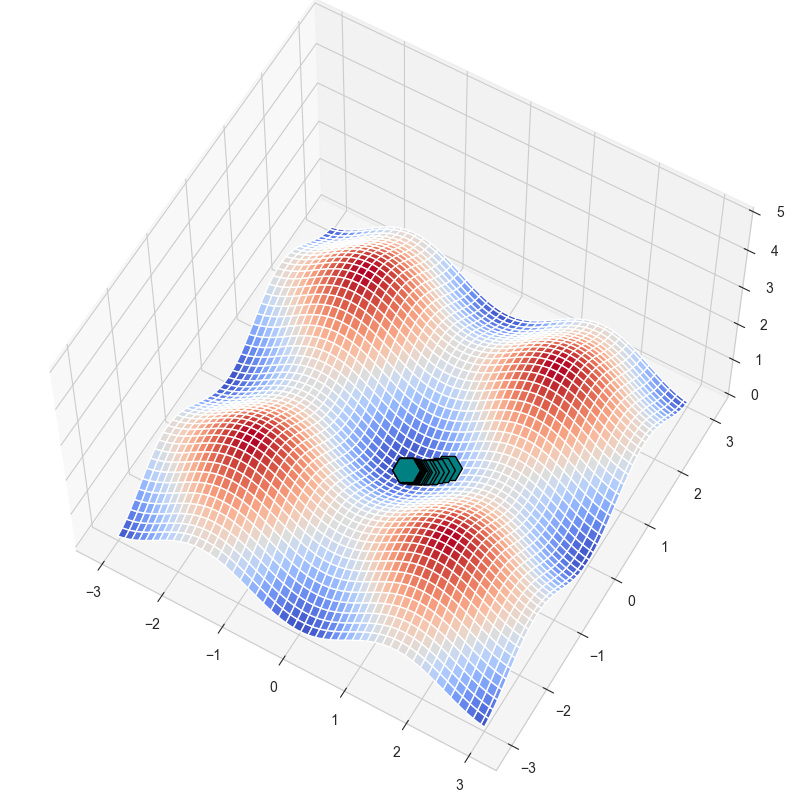

In [297]:
steps = gradient_desc_vis(f, grad_f)

Посмотрим на зависимость значения функции от шага градиентного спуска.

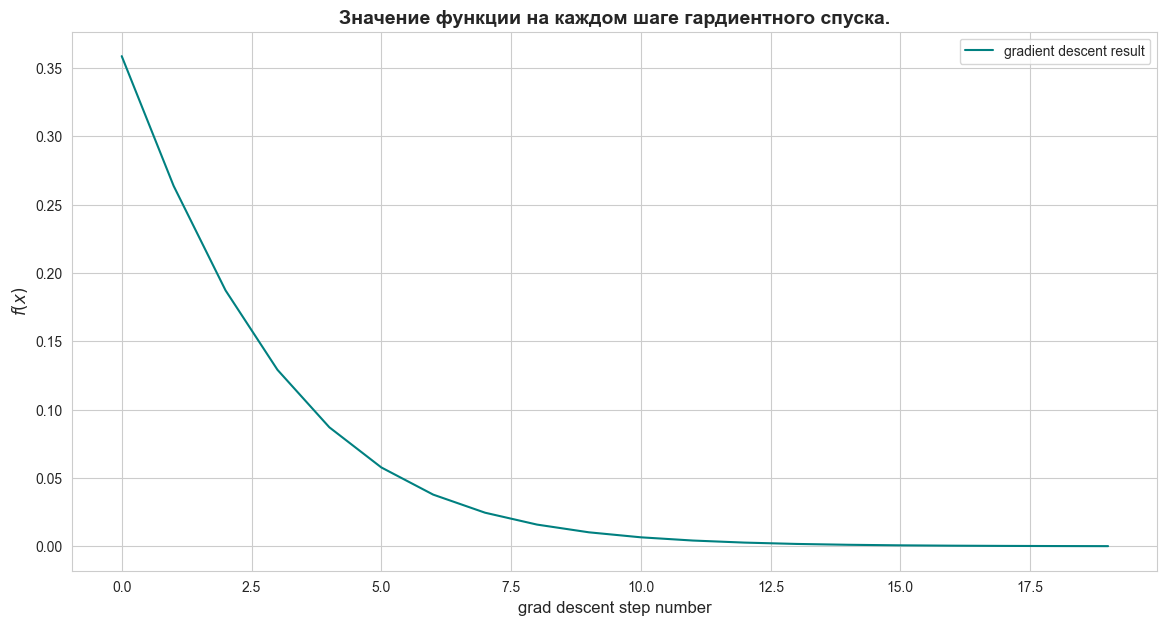

In [298]:
plt.figure(figsize=(14,7))
plt.xlabel("grad descent step number", size=12)
plt.ylabel("$f(x)$", size=12)
plt.title("Значение функции на каждом шаге гардиентного спуска.", size=14, weight='bold')

f_values = list(map(lambda x: x[2], steps))
plt.plot(f_values, label="gradient descent result", color='teal')
plt.legend();

### Задание 2. Реализация линейной регресии (суммарно 9 баллов)

Так как мы будем использовать градиентный спуск для обучения модели, важной частью является реализация функции потерь и функции для расчета ее градиента. Перем началом стоит напомнить, как считать градиент MSE. Вывод этой формулы можно найти  [здесь](https://medium.com/analytics-vidhya/linear-regression-gradient-descent-intuition-and-math-c9a8f5aeeb22)

$$
    MSE = \frac{1}{N}\sum(y_{true} - y_{pred}) ^ 2
$$

$$
    \nabla{MSE} = \frac{2}{N} X^T (y_{pred} - y_{true})
$$

Здесь имеется в виду именно матричное умножение.

#### Задание 2.1. MSE и ее градиент (2 балла)

In [299]:
def mse(y_true, y_pred):
    """
    Функция потерь MSE.
        :param y_true: np.array[n_samples]: вектор из правильных ответов
        :param y_pred: np.array[n_samples]: вектор из предсказаний модели
        :return: значение функции потерь
    """
    
    if  y_true.shape[0] != y_pred.shape[0]:
        raise ValueError("Number of samples in both vectors should be equal")
        
    """
    YOUR CODE IS HERE
    """
    mse = np.sum(np.square(y_true - y_pred)) / y_true.shape[0]
    
    return mse


def mse_grad(y_true, y_pred, X):
    """
    Функция для расчета градиента MSE.
        :param y_true: np.array[n_samples]: вектор из правильных ответов
        :param y_pred: np.array[n_samples]: вектор из предсказаний модели
        :param X: np.array[n_samples, n_features]: матрица объекты x признаки
        :return: градиент функции потерь MSE
    """
    
    if  y_true.shape[0] != y_pred.shape[0]:
        raise ValueError("Number of samples in both vectors should be equal")
        
    """
    YOUR CODE IS HERE
    """    
    mse_grad = 2 * (X.T @ (y_pred - y_true)) / y_true.shape[0]

    return mse_grad


class MSELoss:
    """
    Класс, реализующий функцию потерь MSE. Нужен для того, чтобы
    объединять в одном месте функцию потерь и градиент для нее.
    """
    
    def __call__(self, y_true, y_pred):
        return mse(y_true, y_pred)
    
    def calculate_gradient(self, y_true, y_pred, X):
        return mse_grad(y_true, y_pred, X)

Мы будем использовать следующий класс для расчета градиента наших функций потерь:

In [300]:
class BasicGradientDescent:
    """
    Класс, позволяющий делать шаги градиентного спуска,
    а также рассчитывающих норму градиента.
    """
    
    def __init__(self, loss_function, grad_norm):
        self.loss = loss_function
        self.grad_norm = grad_norm
        
    
    def step(self, y, y_pred, X):
        grad_i = self.loss.calculate_gradient(y, y_pred, X)
        grad_i_norm = self._calculate_grad_norm(grad_i)
        
        return grad_i, grad_i_norm
            
            
    def _calculate_grad_norm(self, grad_i):
        if self.grad_norm == "l1":
            return np.abs(grad_i).sum()
        elif self.grad_norm == "l2":
            return np.sqrt(np.square(grad_i).sum())
        else:
            raise ValueError(f"I can't calculate {self.grad_norm} norm of gradient")

В данном задании нужно будет реализовать линейную регрессию и обучить ее при помощи градиентного спуска. Для этого нужно будет заполнять пропуски кода в соответствующих классах. Для начала мы реализуем базовый класс для всех линейных моделей, от которого потом будем наследоваться при реализации линейной и логистической регресий. Не переживайте, этот класс уже реализован, вам достостаточно просто разобраться с кодом.

In [301]:
class BaseLinearModel:
    """
    Класс, который представляет из себя базовую линейную модель, наследуюясь от которого, мы будем
    реализовывать линейную и логистическую регрессии.
    """
    
    def __init__(self, learning_rate, 
                 loss_function, fit_intercept,
                 n_iter, tol, optimizer, grad_norm):
        """
        Конструктор нашего класса. 
            :param learning_rate: скорость обучения
            :param loss_function: функция потерь (MSE или кросс-энтропия)
            :param fit_intercept: нужно ли нам включать свободных член в модель
            :param n_iter: количество итераций градиентного спуска
            :param tol: параметр для остановки градиентного спуска,
                        если норма градиента (l1 или l2) меньше tol, то останавливаемся
            :param optimizer: класс, который будет рассчитывать градиент и его норму
            :param grad_norm: тип нормы градиента l1 или l2
        """
        
        self.learning_rate = learning_rate
        self.loss = loss_function
        self.fit_intercept = fit_intercept
        self.n_iter = n_iter
        self.tol = tol
        self.grad_norm = grad_norm
        self.optimizer = optimizer(loss_function, grad_norm)
        
        # В начале параметры модели не заданы
        self.W = None
        
        
    def fit(self, X, y):
        """
        Метод для обучения нашей модели 
            :param X: матрица объекты x признаки
            :param y: вектор значений целевой переменной
            :return: обученная модель
        """
        
        # Сделаем из y вектор-столбец (n_samples, 1)
        y = y.reshape(-1, 1)
        n_samples = X.shape[0]
        
        # Добавим колонку из 1 в матрицу X
        if self.fit_intercept:
            ones_column = np.ones((n_samples, 1))
            X_new = np.hstack((ones_column, X))
        
        n_features = X_new.shape[1]
        
        # Инициализируем веса модели
        if self.W is None:
            self.W = np.random.randn(n_features, 1)
        
        # Обучаем модель градиентным спуском
        for i in range(self.n_iter):
            y_pred = self.predict(X)
            grad_i, grad_i_norm = self.optimizer.step(y, y_pred, X_new)
            
            # Если градиент близок к 0, останавливаемся
            if grad_i_norm <= self.tol:
                return self
            
            else:
                self.W -= self.learning_rate * grad_i
        
        return self
    
    
    def predict(self, X):
        raise NotImplementedError("It is a basic class for all linear models. You should implement it for descendant class.")
    
    
    def __repr__(self):
        return "Base linear model without prediction skill :("

#### Задание 2.2. Предсказания линейной регрессии (3 балла)

Реализуйте метод `predict` у класса `CustomLinearRegression`, не забудьте про свободный член!

In [302]:
class CustomLinearRegression(BaseLinearModel):
    def __init__(self, learning_rate: float = 1e-2, 
                 loss_function=MSELoss(), fit_intercept=True,
                 n_iter=1000, tol=1e-5, optimizer=BasicGradientDescent, grad_norm="l1"):
        
        # Если вы не проходили наследование и в частности `super`, то не страшно
        # коротко, с помощью этого мы можем вызывать методы родительского класса
        # в частности здесь мы используем метод `init`
        super().__init__(learning_rate=learning_rate, 
                         loss_function=loss_function, fit_intercept=fit_intercept,
                         n_iter=n_iter, tol=tol, optimizer=optimizer, grad_norm=grad_norm)
        
    
    def predict(self, X_test):
        """
        Метод для вычисления предсказаний 
            :param X_test: np.array[n_test_samples, n_features]: 
                           матрица объекты x признаки (тестовый датасет)
            :return: y_pred: np.array[n_test_samples, 1]: предсказания модели
        """
        
        if self.W is None:
            raise NotFittedError("This CustomLinearRegression instance is not fitted yet, run fit method.")
        
        n_test_samples = X_test.shape[0]
        if self.fit_intercept:
            ones_column = np.ones((n_test_samples, 1))
            X_test = np.hstack((ones_column, X_test))
            
        y_pred = X_test @ self.W
        
        return y_pred
    
    
    def __repr__(self):
        return "My custom linear regression"

##### Проверим нашу реализацию на простом примере

In [303]:
X = np.random.randn(100, 1)
y = 2 * X + 5 + 0.5 * np.random.randn(100, 1)

''

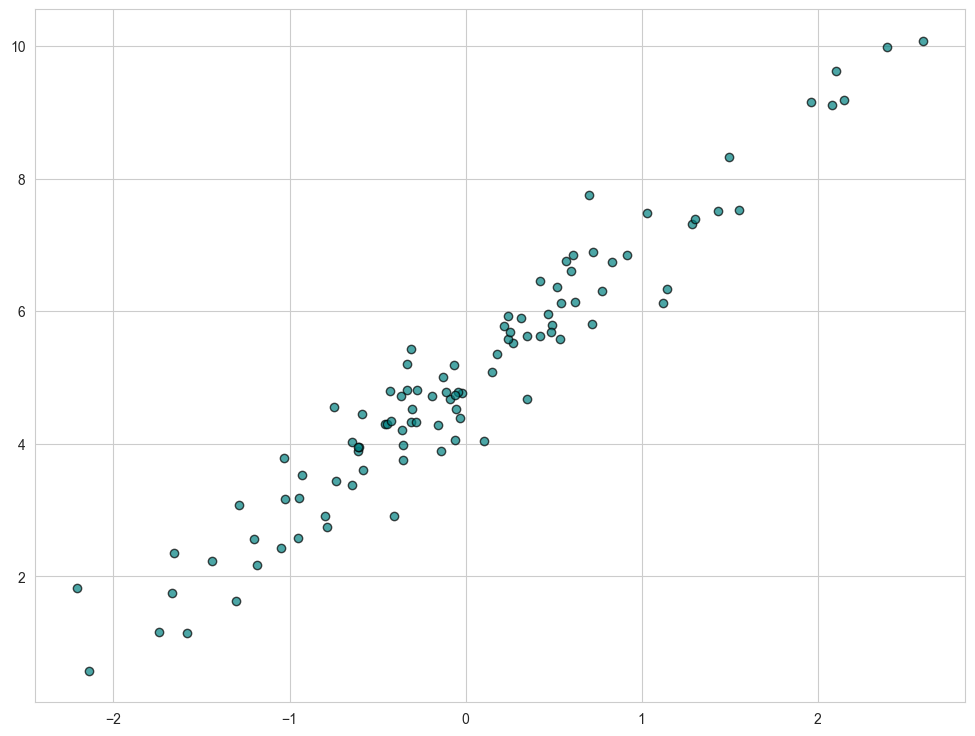

In [304]:
plt.scatter(X, y, color='teal', edgecolor='black', alpha=0.7)
;

In [305]:
custom_lin_reg = CustomLinearRegression()

In [306]:
custom_lin_reg.fit(X, y)

My custom linear regression

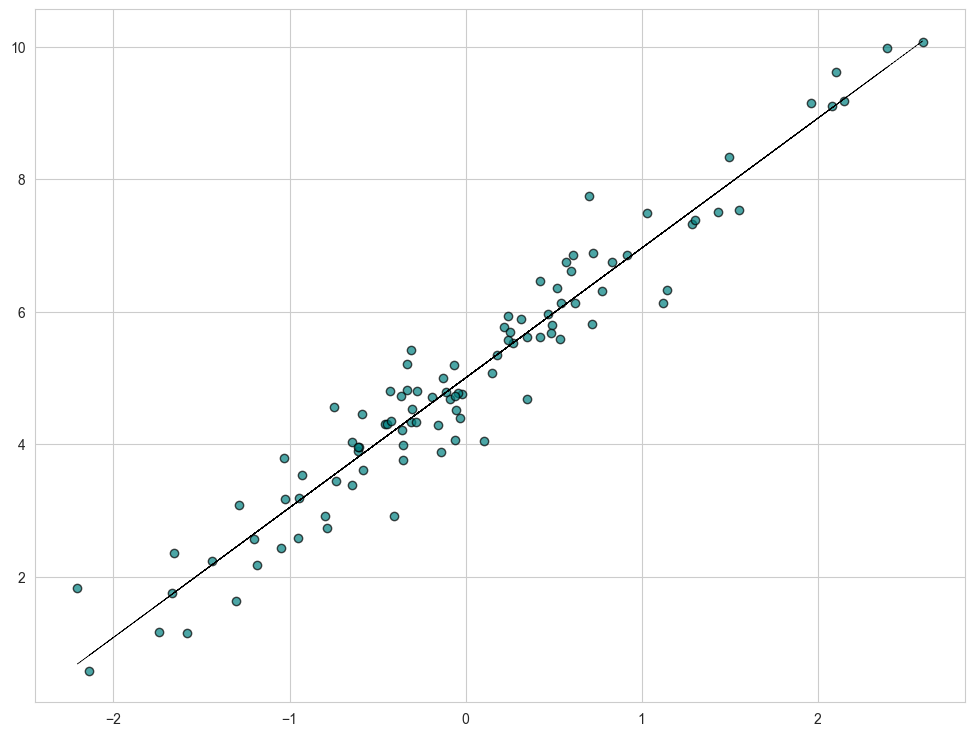

In [307]:
plt.scatter(X, y, color='teal', edgecolor='black', alpha=0.7)
plt.plot(X, custom_lin_reg.predict(X), color='black', linestyle='--', linewidth=0.5);

#### Задание 2.3. Используем встроенную линейную регрессию (4 балла)

Поработаем с данными о ценах на дома в Калифорнии. Постройте модель линейной регресии при помощи `LinearRegression` из `sklearn`. Не забудьте разделить данные на тренировочную и тестовую части, а также правильно предобработать признаки. В конце воспользуйтесь какими-то изученными метриками регресии и сделайте выводы о качестве полученной модели, а также о том, какие признаки наиболее важны с точки зрения полученной модели.

In [308]:
data = fetch_california_housing()
X, y = data["data"], data["target"]
feature_names = data["feature_names"]

Ваш ход:

EDA

In [309]:
X.shape, y.shape

((20640, 8), (20640,))

In [310]:
print('Are the data standardized?')
for feature in feature_names:
    print(f'{feature}: mean: {X[ : , feature_names.index(feature)].mean()}; std: {X[ : , feature_names.index(feature)].std()}')
print("Data need to be standardized.")

Are the data standardized?
MedInc: mean: 3.8706710029069766; std: 1.8997756945748738
HouseAge: mean: 28.639486434108527; std: 12.585252725724606
AveRooms: mean: 5.428999742190376; std: 2.474113202333516
AveBedrms: mean: 1.096675149606208; std: 0.47389937625774475
Population: mean: 1425.4767441860465; std: 1132.434687757615
AveOccup: mean: 3.0706551594363742; std: 10.385797959128219
Latitude: mean: 35.63186143410853; std: 2.135900653797483
Longitude: mean: -119.56970445736432; std: 2.003483187746976
Data need to be standardized.


In [311]:
print('Will I have to do sth with NAs? Are all features numerical or some of them are categorial?')
for feature in feature_names:
    print(f'{feature}: zeros: {X.shape[0] - np.count_nonzero(X[ : , feature_names.index(feature)])}, unique values: {np.unique(X[ : , feature_names.index(feature)]).shape[0]}')
print('No, hopefully, no NAs in the dataset and all features are numerical.')

Will I have to do sth with NAs? Are all features numerical or some of them are categorial?
MedInc: zeros: 0, unique values: 12928
HouseAge: zeros: 0, unique values: 52
AveRooms: zeros: 0, unique values: 19392
AveBedrms: zeros: 0, unique values: 14233
Population: zeros: 0, unique values: 3888
AveOccup: zeros: 0, unique values: 18841
Latitude: zeros: 0, unique values: 862
Longitude: zeros: 0, unique values: 844
No, hopefully, no NAs in the dataset and all features are numerical.


Let's see the distribution plots of the features. The features are distributed far from normal....

''

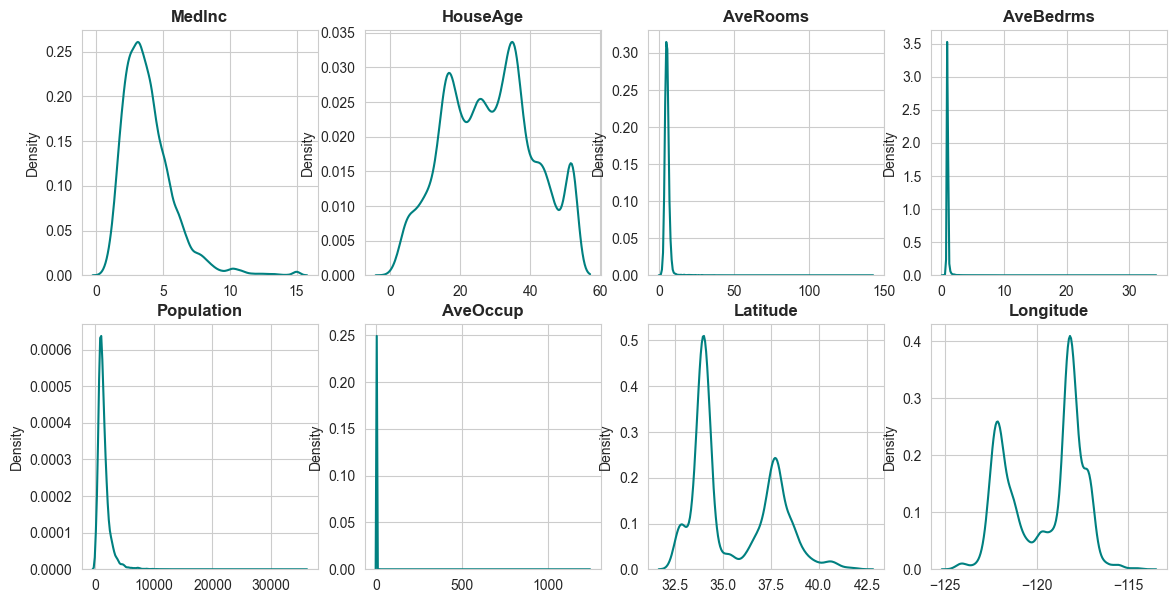

In [312]:
fig, axes = plt.subplots(2, 4, figsize=(14, 7))
axes = axes.ravel()
for feature, axis in enumerate(axes):
    sns.kdeplot(X[:, feature], ax=axis, color='teal')
    axis.set_title(feature_names[feature], weight='bold')
;

As far as we plan to use linear model, we need to check whether all features have linear connection with target.

According to the plot it seems that linear regression actually would not be the best choice for us.

''

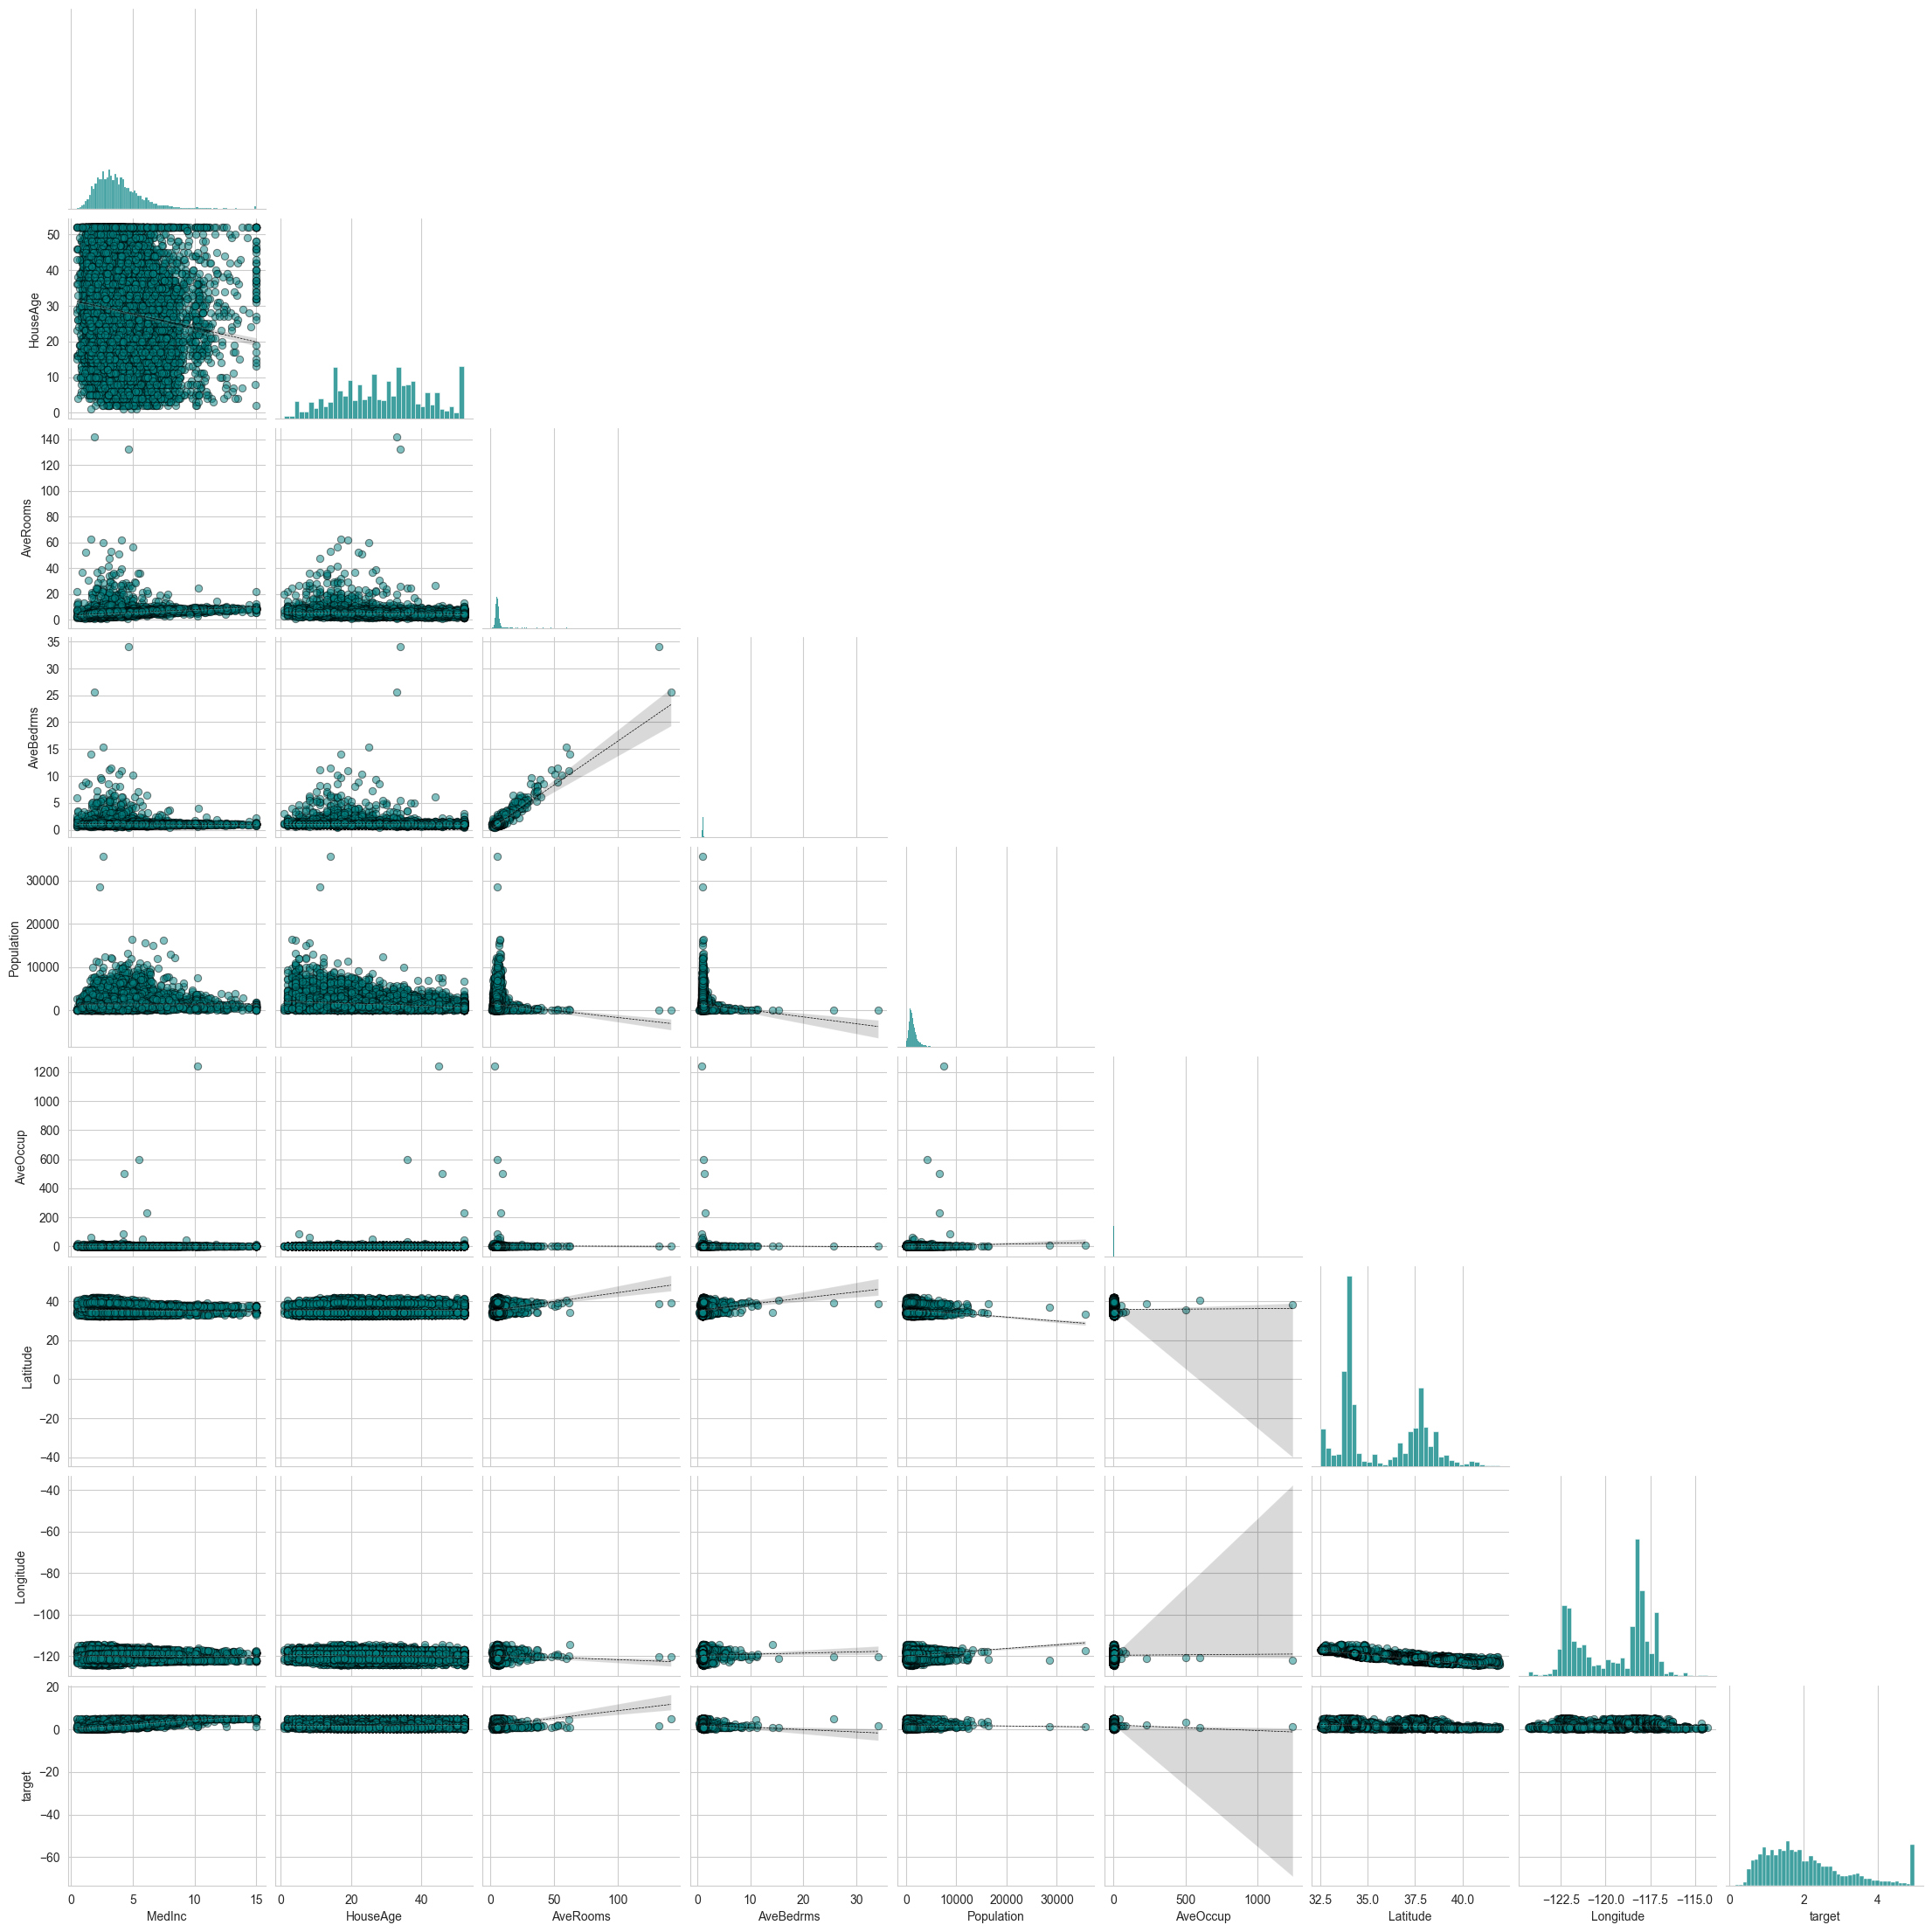

In [313]:
houses = pd.concat([pd.DataFrame(data=X, columns=feature_names), pd.DataFrame(data=y, columns=['target'])], axis=1)
sns.pairplot(houses, kind='reg', corner=True, diag_kws={'color':'teal'}, plot_kws={'color':'teal', 
             'scatter_kws': {'edgecolors': 'black', 'linewidths': 0.7, 'alpha': 0.5}, 
             'line_kws': {'color': 'black', 'linewidth': 0.5, 'linestyle': '--'}})
;

In [314]:
x_df = houses.drop('target', axis=1)

Do features correlate? Unfortunately yes.

''

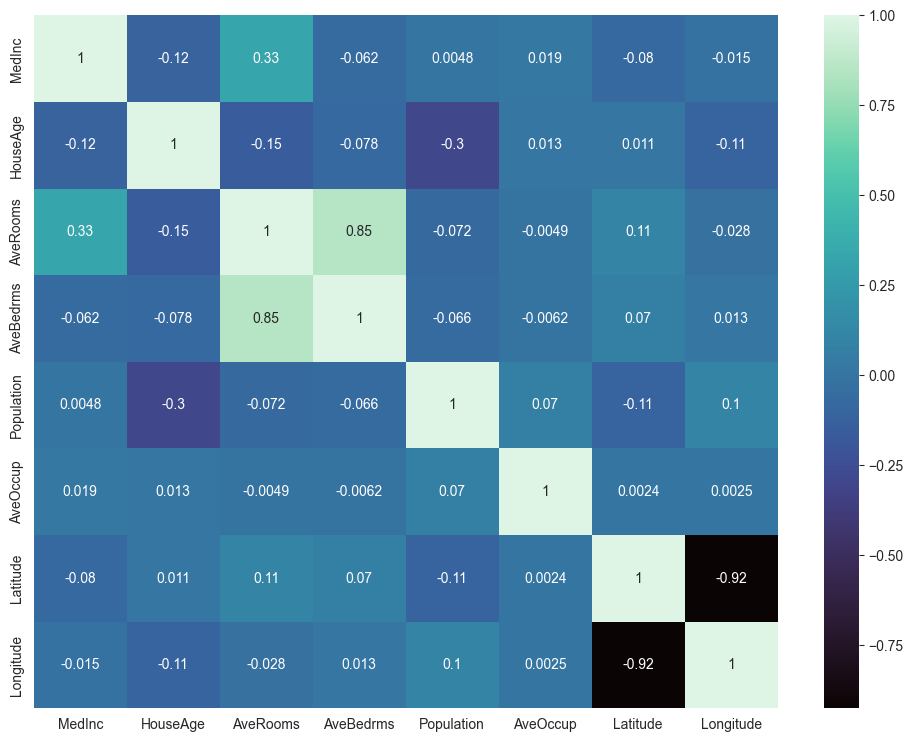

In [315]:
sns.heatmap(x_df.corr(), cmap='mako', annot=True)
;

Two pairs of features that correlate the most are *Latitude* + *Longitude* and  and *AveRooms* + *AveBedrms*. 

Out of each pair I will drop one of the features that least correlates with target.

In [316]:
np.corrcoef(X[ : , feature_names.index('Latitude')], y)

array([[ 1.        , -0.14416028],
       [-0.14416028,  1.        ]])

In [317]:
np.corrcoef(X[ : , feature_names.index('Longitude')], y)

array([[ 1.        , -0.04596662],
       [-0.04596662,  1.        ]])

*Longitude* correlates to target less than *Latitude*, so I'll exclude *Longitude*.

In [318]:
np.corrcoef(X[ : , feature_names.index('AveRooms')], y)

array([[1.        , 0.15194829],
       [0.15194829, 1.        ]])

In [319]:
np.corrcoef(X[ : , feature_names.index('AveBedrms')], y)

array([[ 1.        , -0.04670051],
       [-0.04670051,  1.        ]])

*AveBedrms* correlates to target less than *AveBedrms* so I'll exclude *AveBedrms*.

In [320]:
x_df = x_df.drop(['Longitude', 'AveBedrms'], axis=1)

In [321]:
test_proportion = 0.25
X_train, X_test, y_train, y_test = train_test_split(x_df, y, test_size=test_proportion, random_state=SEED)

In [322]:
lm_pipeline = Pipeline(steps=[
    ('scaler', StandardScaler()), 
    ('lm', LinearRegression())
    ])
lm_pipeline.fit(X_train, y_train)
y_pred = lm_pipeline.predict(X_test)
y_pred_train = lm_pipeline.predict(X_train)

In [323]:
print('Metrics for test set:')
print(
    f'R2-score: {r2_score(y_test, y_pred)}'
    '\n'
    f'MSE-score: {mean_squared_error(y_test, y_pred)}'
    '\n'
    f'MAE-score: {mean_absolute_error(y_test, y_pred)}'
)

Metrics for test set:
R2-score: 0.50679714365667
MSE-score: 0.6634341608209382
MAE-score: 0.6002221980469676


In [324]:
print('Metrics for train set:')
print(
    f'R2-score: {r2_score(y_train, y_pred_train)}'
    '\n'
    f'MSE-score: {mean_squared_error(y_train, y_pred_train)}'
    '\n'
    f'MAE-score: {mean_absolute_error(y_train, y_pred_train)}'
)

Metrics for train set:
R2-score: 0.5252761636691998
MSE-score: 0.6299013268937864
MAE-score: 0.5918420481057327


I'd prefer to use R2 as the main metric because MAE and MSE values depend on target values. However, MSE and MAE that accompany R2, especially while comparing metrics obtained on train and test datasets predictions, help me understand that the model is not perfect because R2 is around 0.5. But I can see as well that R2, MSE and MAE values are close in train and test dataset predictions and that might be a good indicator that our model was neither underfitted nor overfitted.

Now let's see feature importances.

''

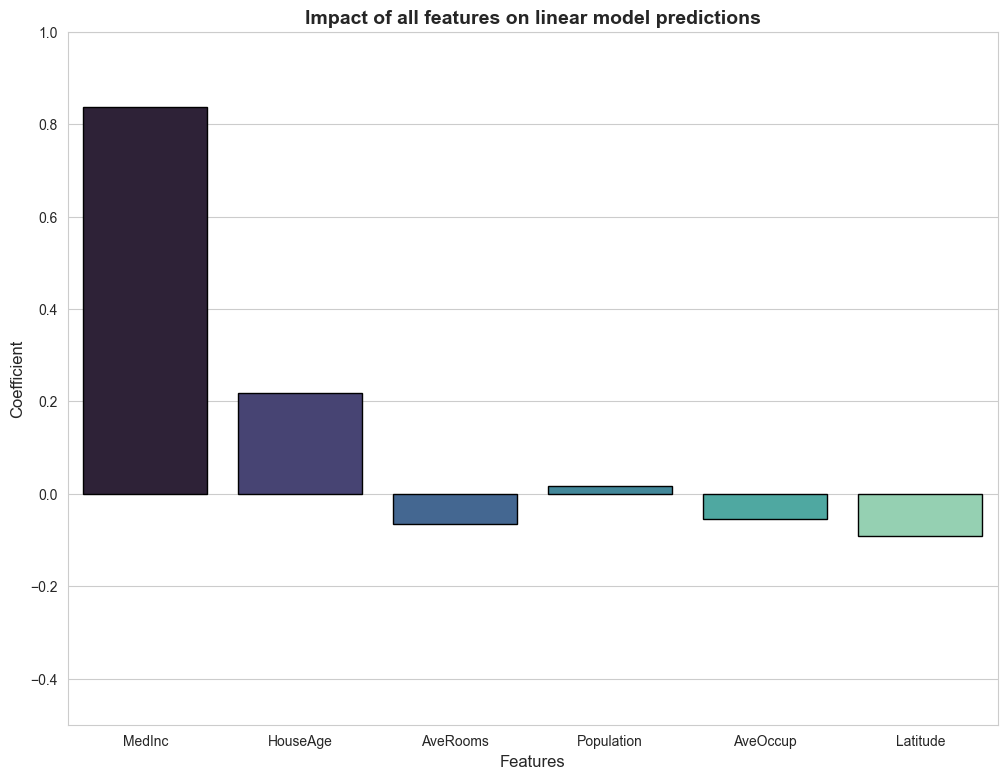

In [325]:
sns.barplot(x=x_df.columns, y=lm_pipeline[1].coef_, palette='mako', edgecolor='black')
plt.title('Impact of all features on linear model predictions', size=14, weight='bold')
plt.ylabel('Coefficient', size=12)
plt.xlabel('Features', size=12)
plt.ylim([-0.5, 1])
;

As we can see, the **MedInc** feature (stands for median income in block group) is the most important feature for the model. That seems pretty logical: the more area's residents earn, the more prestigeous household they prefer and have more requests concerning life quality and luxury infrastructure close to their houses.

Second most important feature is **HouseAge**: the older is the house, the more it's price is.

Third most important feature is **Latitude**: it seems interesting that the price of household in California depends on its geographic location.

In [326]:
residuals = y_test - y_pred

''

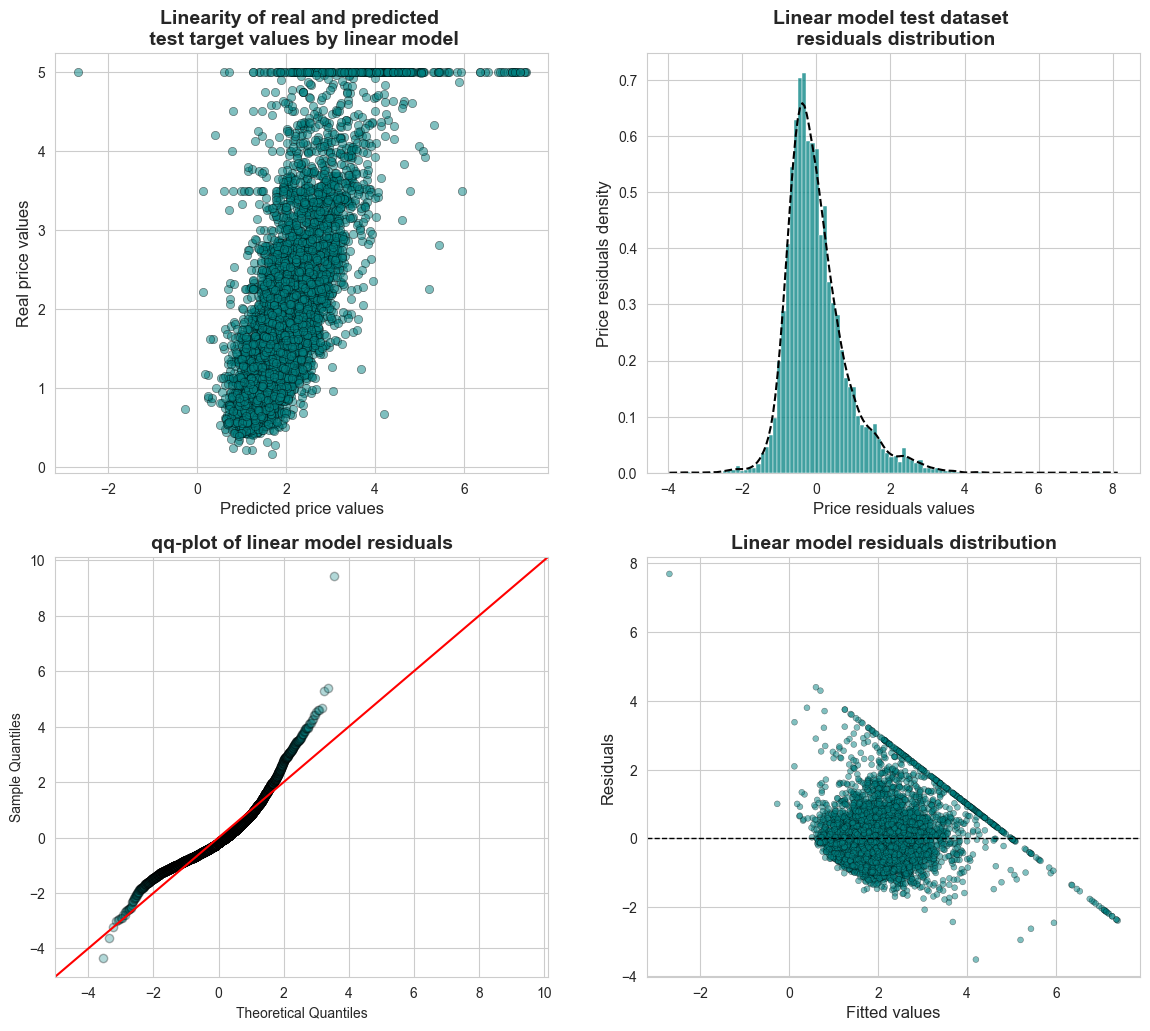

In [327]:
fig, axes = plt.subplots(2, 2, figsize=(14, 12))

sns.scatterplot(x=y_pred, y=y_test, color='teal', edgecolor='black', alpha=0.5, ax=axes[0][0])
axes[0][0].set_title('Linearity of real and predicted \n test target values by linear model', size=14, weight='bold')
axes[0][0].set_xlabel('Predicted price values', size=12)
axes[0][0].set_ylabel('Real price values', size=12)

sns.histplot(residuals, bins=100, stat='density', color='teal', ax=axes[0][1])
sns.kdeplot(residuals, color='black', linestyle='--', ax=axes[0][1])
axes[0][1].set_title('Linear model test dataset \n residuals distribution', size=14, weight='bold')
axes[0][1].set_ylabel('Price residuals density', size=12)
axes[0][1].set_xlabel('Price residuals values', size=12)

sm.qqplot(residuals, line='45', fit=True, markerfacecolor='teal', markeredgecolor='black', alpha=0.3, ax=axes[1][0])
axes[1][0].set_title('qq-plot of linear model residuals', size=14, weight='bold')

sns.scatterplot(x=y_pred, y=residuals, color='teal', edgecolor='black', alpha=0.5, size=3, legend=False, ax=axes[1][1])
axes[1][1].set_title('Linear model residuals distribution', size=14, weight='bold')
axes[1][1].set_ylabel('Residuals', size=12)
axes[1][1].set_xlabel('Fitted values', size=12)
axes[1][1].axhline(0, -5, 45, color='black', linewidth=1, linestyle='--')
axes[1][1].set_ylim([min(residuals) - 0.5, max(residuals) + 0.5])
;

As we can see on the four plots above, the linear model is actually not a good choice for this dataset because of non-normal distribution of residuals confirmed by qq-plot and no homoscedasticity of residuals.

### Задание 3. Реализация логистической регресии (суммарно 10 баллов)

Логистическая регрессия не очень сильно отличается от обычной линейной регрессии и используется в задах классификации. Так как здесь мы снова будем пользоваться градиентным спуском, то нужно определить функцию потерь и ее градиент. Одним из самых популярных вариантов в задаче бинарной классификации является бинарная кросс-энтропия (BCE).

$$\mathcal L_{BCE}(y, \hat y) = -\sum_i \left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

где $y$ это  таргет желаемого результата и $\hat y$ является выходом модели. $\sigma$ - это [*логистическая* функция](https://en.wikipedia.org/wiki/Sigmoid_function), который преобразует действительное число $\mathbb R$ в вероятность $[0,1]$.

Единственная проблема данной функции это возможность получить 0 под знаком логарифма, что не очень хорошо. Попробуем справить с этим "в лоб". Скажем, что наши предсказания могут принимать значения от 0 + eps до 1 - eps, где eps очень маленькое число.

#### Задание 3.1. Реализация сигмоиды (0.5 баллов)

Реализуйте функцию `sigmoid`, которая переводит действительное число $\mathbb R$ в вероятность $[0,1]$.

In [328]:
def sigmoid(output):
    # output результат X@w (-inf, +inf)
    
    sigma = 1 / (1 + np.e ** (- output))
    return sigma

#### Задание 3.2. BCE Loss и ее градиент (2.5 балла)

Так как мы с вами только начинаем изучать машинное обучение, то было бы слишком жестоко просить вас вычислить градиент BCE Loss (он не так сложен, просто нужно привыкнуть). Поэтому сразу напишем формулу для него:

$$
\nabla{\mathcal L_{BCE}(y, \hat y), X} = X^T (\sigma({\hat{y}}) - y)
$$

In [329]:
def bce(y_true, y_pred, eps=1e-15):
    """
    Функция потерь BCE.
        :param y_true: np.array[n_samples]: вектор из правильных ответов 0/1
        :param y_pred: np.array[n_samples]: вектор из предсказаний модели (вероятности)
        :return: значение функции потерь
    """
    
    if  y_true.shape[0] != y_pred.shape[0]:
        raise ValueError("Number of samples in both vectors should be equal")
        
    n = y_true.shape[0]
    
    # So I want escape log(0)
    y_pred = np.clip(y_pred, eps, 1 - eps)
    
    bcelss = - (np.sum(y_true * np.log(y_pred) + (1 - y_true) * np.log(1 - y_pred))) / n
    return bcelss
    

def bce_grad(y_true, y_pred, X):
    """
    Функция потерь BCE.
        :param y_true: np.array[n_samples]: вектор из правильных ответов 0/1
        :param y_pred: np.array[n_samples]: вектор из предсказаний модели (вероятности)
        :param X: np.array[n_samples, n_features]: матрица объекты x признаки
        :return: значение функции потерь
    """
    
    if  y_true.shape[0] != y_pred.shape[0]:
        raise ValueError("Number of samples in both vectors should be equal")
        
    bcelss_grad = X.T @ (y_pred - y_true)
    return bcelss_grad


class BCELoss:
    """
    Класс, реализующий функцию потерь BCE. Нужен для того, чтобы
    объединять в одном месте функцию потерь и градиент для нее.
    """
    
    def __call__(self, y_true, y_pred):
        return bce(y_true, y_pred)
    
    def calculate_gradient(self, y_true, y_pred, X):
        return bce_grad(y_true, y_pred, X)

#### Задание 3.3. Предсказания логистической регрессии (2 балла)

Реализуйте метод `predict` у класса `CustomLogisticRegression`, не забудьте про свободный член!

In [330]:
class CustomLogisticRegression(BaseLinearModel):
    def __init__(self, learning_rate: float = 1e-3,
                 loss_function=BCELoss(), fit_intercept=True,
                 n_iter=1000, tol=1e-5, optimizer=BasicGradientDescent, grad_norm="l1"):
        
        super().__init__(learning_rate=learning_rate,
                         loss_function=loss_function, fit_intercept=fit_intercept,
                         n_iter=n_iter, tol=tol, optimizer=optimizer, grad_norm=grad_norm)
    
    
    def predict(self, X_test):
        if self.W is None:
            raise NotFittedError("This CustomLogisticRegression instance is not fitted, run fit method.")
        
        n_test_samples = X_test.shape[0]
        if self.fit_intercept:
            ones_column = np.ones((n_test_samples, 1))
            X_test = np.hstack((ones_column, X_test))
            
        y_pred = sigmoid(X_test @ self.W)
        return y_pred
    
    
    def __repr__(self):
        return "My custom logistic regression"

#### Снова проверим работу алгоритма на простом примере

In [331]:
# Создадим датасет из 1 признака и 2 классов
X, y = make_classification(n_features=1, n_informative=1,
                           n_redundant=0, n_clusters_per_class=1)

''

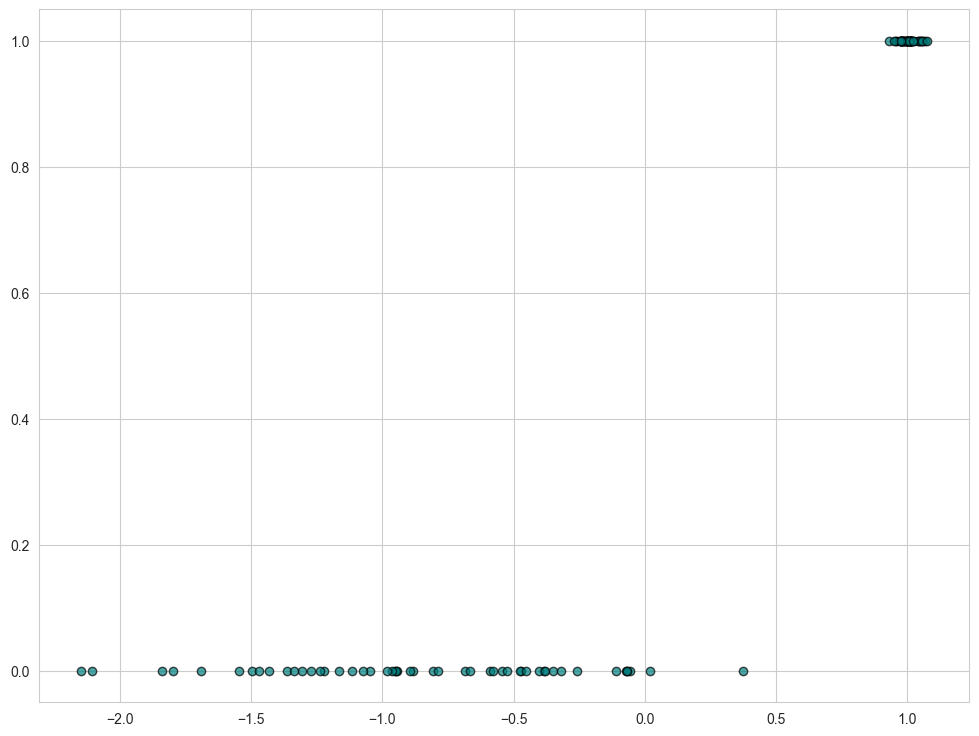

In [332]:
plt.scatter(X, y,  color='teal', edgecolor='black', alpha=0.7)
;

In [333]:
custom_log_reg = CustomLogisticRegression()
custom_log_reg.fit(X, y)
y_pred = custom_log_reg.predict(X)

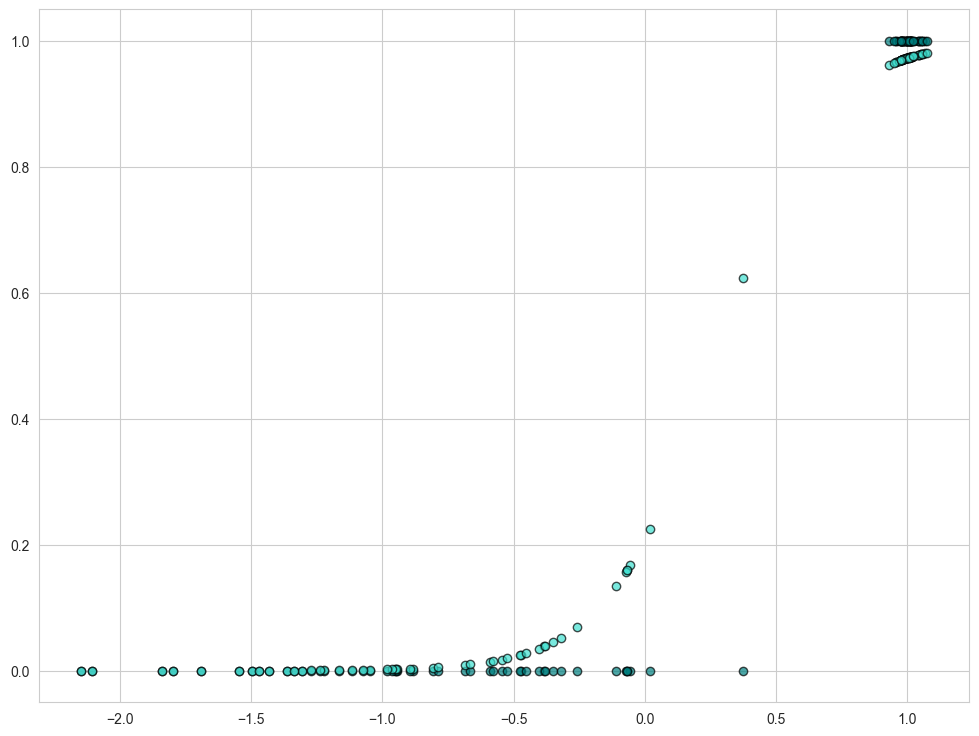

In [334]:
plt.scatter(X, y, color='teal', edgecolor='black', alpha=0.7)
plt.scatter(X, y_pred, color='turquoise', edgecolor='black', alpha=0.7);

Проверьте качество работы модели при помощи известных вам метрик бинарной классификации.

In [335]:
y_pred_bin = (y_pred > 0.5) * 1

In [336]:
print(f'Precision score: {precision_score(y, y_pred_bin)}')
print(f'Recall score: {recall_score(y, y_pred_bin)}')
print(f'F1-score score: {f1_score(y, y_pred_bin)}')
print(f'Accuracy score: {accuracy_score(y, y_pred_bin)}')

Precision score: 0.9803921568627451
Recall score: 1.0
F1-score score: 0.99009900990099
Accuracy score: 0.99


#### Задание 3.4. Применение логистической регрессии (5 баллов)

Мы будем использовать данные по свойствам покемонов (https://www.kaggle.com/abcsds/pokemon). В данном задании вам необходимо сначала сделать краткий EDA (Посмотреть на данные и их распределения, а также посмотреть, как различные признаки связаны между собой и с целевой переменной (`Legendary`)).

In [337]:
pokemon = pd.read_csv("../data/Pokemon.csv")
pokemon.head()

,#,Name,Type 1,Type 2,Total,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,Legendary
0,1,Bulbasaur,Grass,Poison,318,45,49,49,65,65,45,1,False
1,2,Ivysaur,Grass,Poison,405,60,62,63,80,80,60,1,False
2,3,Venusaur,Grass,Poison,525,80,82,83,100,100,80,1,False
3,3,VenusaurMega Venusaur,Grass,Poison,625,80,100,123,122,120,80,1,False
4,4,Charmander,Fire,NaN,309,39,52,43,60,50,65,1,False


Мы будем предсказывать является ли покемон легендарным или нет. Замените логическое значение колонки на числовое (перекодировав на 0 и 1). Также подумайте, как в этом случае лучше закодировать категориальные признаки (может быть, лучше их просто выбросить?).

In [338]:
pokemon.shape

(800, 13)

In [339]:
pokemon.describe()

,#,Total,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation
count,800.000000,800.00000,800.000000,800.000000,800.000000,800.000000,800.000000,800.000000,800.00000
mean,362.813750,435.10250,69.258750,79.001250,73.842500,72.820000,71.902500,68.277500,3.32375
std,208.343798,119.96304,25.534669,32.457366,31.183501,32.722294,27.828916,29.060474,1.66129
min,1.000000,180.00000,1.000000,5.000000,5.000000,10.000000,20.000000,5.000000,1.00000
25%,184.750000,330.00000,50.000000,55.000000,50.000000,49.750000,50.000000,45.000000,2.00000
50%,364.500000,450.00000,65.000000,75.000000,70.000000,65.000000,70.000000,65.000000,3.00000
75%,539.250000,515.00000,80.000000,100.000000,90.000000,95.000000,90.000000,90.000000,5.00000
max,721.000000,780.00000,255.000000,190.000000,230.000000,194.000000,230.000000,180.000000,6.00000


In [340]:
pokemon.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 800 entries, 0 to 799
Data columns (total 13 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   #           800 non-null    int64 
 1   Name        800 non-null    object
 2   Type 1      800 non-null    object
 3   Type 2      414 non-null    object
 4   Total       800 non-null    int64 
 5   HP          800 non-null    int64 
 6   Attack      800 non-null    int64 
 7   Defense     800 non-null    int64 
 8   Sp. Atk     800 non-null    int64 
 9   Sp. Def     800 non-null    int64 
 10  Speed       800 non-null    int64 
 11  Generation  800 non-null    int64 
 12  Legendary   800 non-null    bool  
dtypes: bool(1), int64(9), object(3)
memory usage: 75.9+ KB


*Type 2* is defined not for every pokemon.

In [341]:
pokemon['Type 2'].unique()

array(['Poison', nan, 'Flying', 'Dragon', 'Ground', 'Fairy', 'Grass',
       'Fighting', 'Psychic', 'Steel', 'Ice', 'Rock', 'Dark', 'Water',
       'Electric', 'Fire', 'Ghost', 'Bug', 'Normal'], dtype=object)

In [342]:
pokemon['Type 2'] = pokemon['Type 2'].fillna('NoType')

In [343]:
for col in pokemon:
    print(f'{col}: {len(pokemon[col].unique())}')

#: 721
Name: 800
Type 1: 18
Type 2: 19
Total: 200
HP: 94
Attack: 111
Defense: 103
Sp. Atk: 105
Sp. Def: 92
Speed: 108
Generation: 6
Legendary: 2


So, first of all, columns *#* and *name* shall be dropped because number of pokemon in the dataset is not a predictive feature. There are only 721 # for 800 pokemons because some of them are simple and others are mega and obviously they might have different characteristics. Name of a pokemon is unique and has no importance for our dataset.

Among other features *Type1*, *Type2*, *Generation* and *Legendary* (target) are categorical.

In [344]:
pokemon['target'] = pokemon['Legendary'].astype(int)

In [345]:
pokemon = pokemon.drop(['#', 'Name', 'Legendary'], axis=1)
pokemon

,Type 1,Type 2,Total,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,target
0,Grass,Poison,318,45,49,49,65,65,45,1,0
1,Grass,Poison,405,60,62,63,80,80,60,1,0
2,Grass,Poison,525,80,82,83,100,100,80,1,0
3,Grass,Poison,625,80,100,123,122,120,80,1,0
4,Fire,NoType,309,39,52,43,60,50,65,1,0
...,...,...,...,...,...,...,...,...,...,...,...
795,Rock,Fairy,600,50,100,150,100,150,50,6,1
796,Rock,Fairy,700,50,160,110,160,110,110,6,1
797,Psychic,Ghost,600,80,110,60,150,130,70,6,1
798,Psychic,Dark,680,80,160,60,170,130,80,6,1


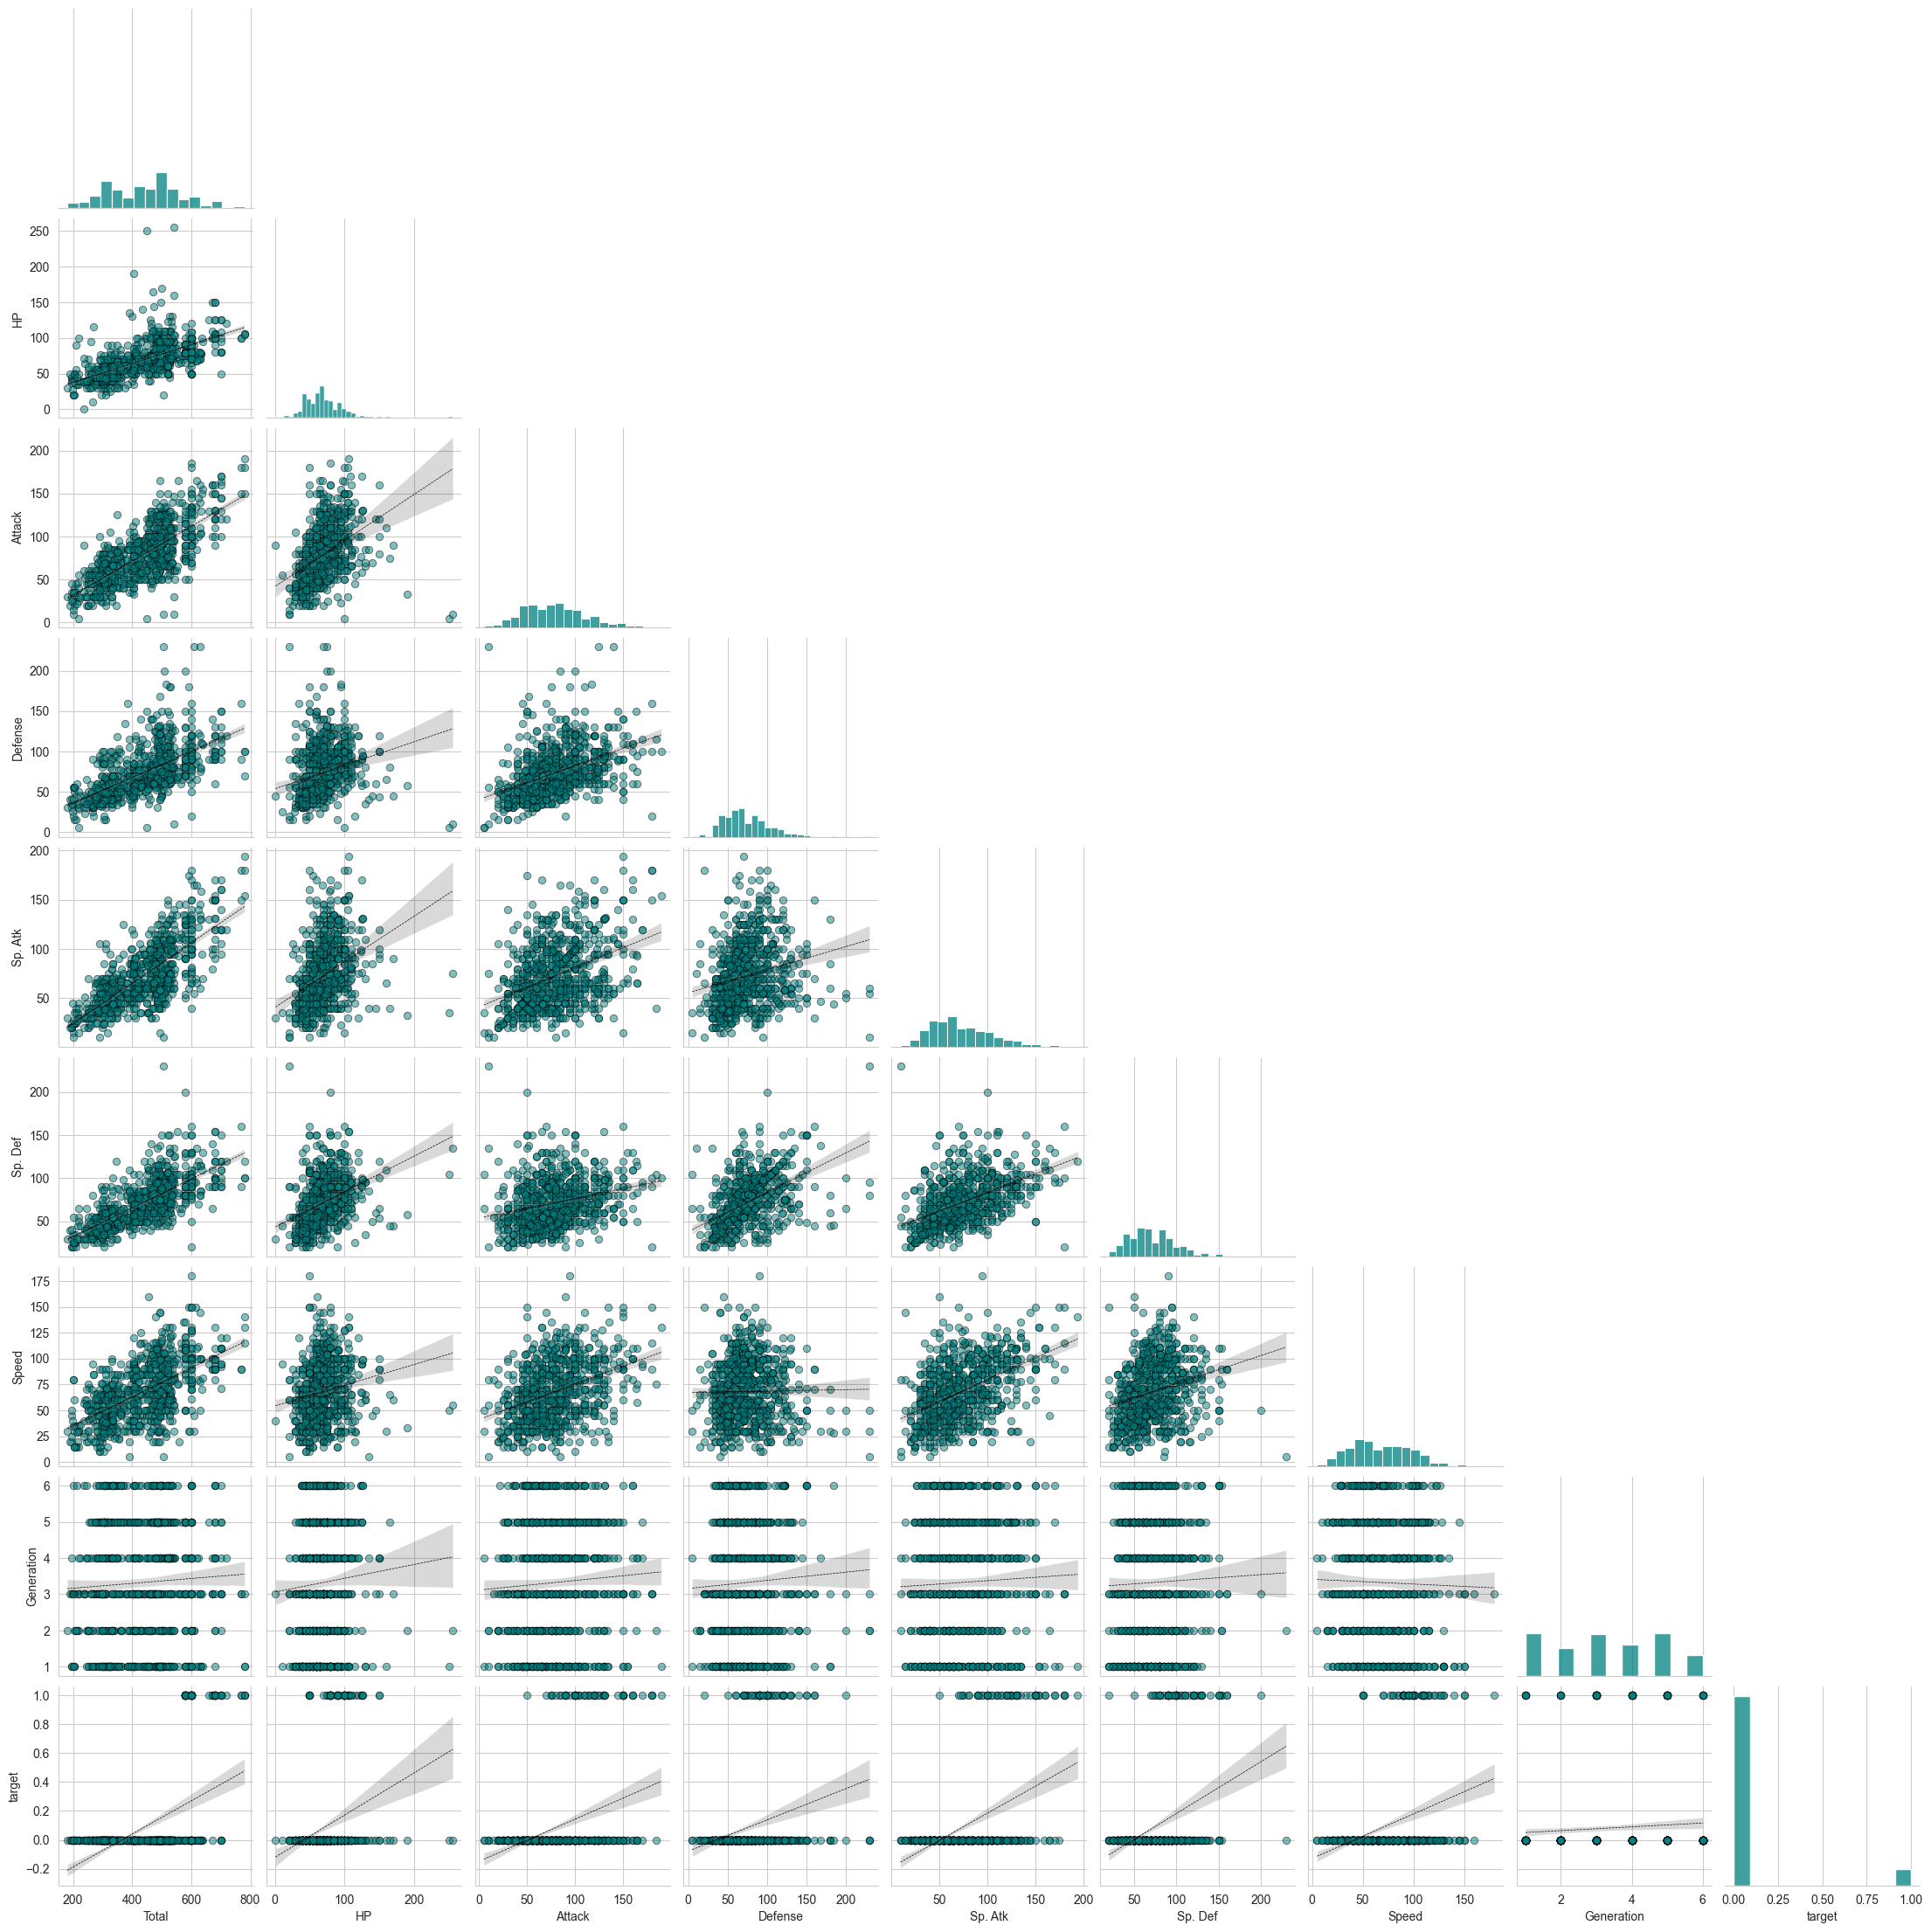

In [346]:
sns.pairplot(pokemon, kind='reg', corner=True, diag_kws={'color':'teal'}, plot_kws={'color':'teal', 
             'scatter_kws': {'edgecolors': 'black', 'linewidths': 0.7, 'alpha': 0.5}, 
             'line_kws': {'color': 'black', 'linewidth': 0.5, 'linestyle': '--'}})

We can see class disbalance: there are more not legendary than not legendary pokemons. *Total* correlates with most of other features, so I'll drop it.

In [347]:
pokemon = pokemon.drop('Total', axis=1)

In [348]:
pokemon

,Type 1,Type 2,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,target
0,Grass,Poison,45,49,49,65,65,45,1,0
1,Grass,Poison,60,62,63,80,80,60,1,0
2,Grass,Poison,80,82,83,100,100,80,1,0
3,Grass,Poison,80,100,123,122,120,80,1,0
4,Fire,NoType,39,52,43,60,50,65,1,0
...,...,...,...,...,...,...,...,...,...,...
795,Rock,Fairy,50,100,150,100,150,50,6,1
796,Rock,Fairy,50,160,110,160,110,110,6,1
797,Psychic,Ghost,80,110,60,150,130,70,6,1
798,Psychic,Dark,80,160,60,170,130,80,6,1


Разделите ваши данные на тестовую и тренировочную выборку.

In [349]:
X = pokemon.drop('target', axis=1)
y = pokemon.target

In [350]:
test_proportion = 0.25
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_proportion, random_state=SEED)

Need to ckeck the class disbalance in target.

In [351]:
sum(y_train) / len(y_train), sum(y_test) / len(y_test)

(0.07166666666666667, 0.11)

Preprocessor for standardizing

In [352]:
num_cols = ['HP', 'Attack', 'Defense', 'Sp. Atk', 'Sp. Def',
       'Speed']
cat_cols = ['Type 1', 'Type 2', 'Generation']
all_cols = num_cols + cat_cols

preprocessor = ColumnTransformer(
    transformers=[("scaler", StandardScaler(), num_cols),
                  ("ohe", OneHotEncoder(drop="first"), cat_cols)]
)

Обучите модель `LogisticRegression` из `sklearn`.

In [353]:
log_reg_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('log regression', LogisticRegression())
])

In [354]:
log_reg_pipeline.fit(X_train, y_train)
y_pred_test = log_reg_pipeline.predict(X_test)
y_pred_train = log_reg_pipeline.predict(X_train)

Выведите метрики вашего классификатора:

1. Нарисуйте [confusion matrix](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.plot_confusion_matrix.html).

2. Изобразите ROC кривую и посчитайте площадь под ней.

3. Скажите, какие признаки оказались наиболее важны для модели.

''

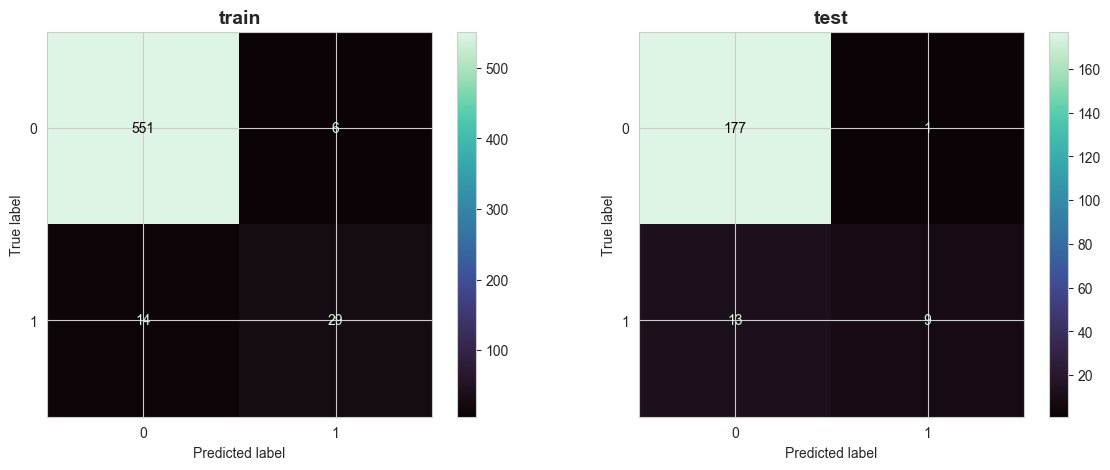

In [389]:
fig, ax = plt.subplots(1, 2, figsize=(14, 5))
ax[0].set_title("train", size=14, weight='bold')
ax[1].set_title("test", size=14, weight='bold')

cm_train = confusion_matrix(y_train, y_pred_train, labels=log_reg_pipeline[1].classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_train,
                              display_labels=log_reg_pipeline[1].classes_)
disp.plot(ax=ax[0], cmap='mako')

cm_test = confusion_matrix(y_test, y_pred_test, labels=log_reg_pipeline[1].classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_test,
                              display_labels=log_reg_pipeline[1].classes_)
disp.plot(ax=ax[1], cmap='mako')
;

''

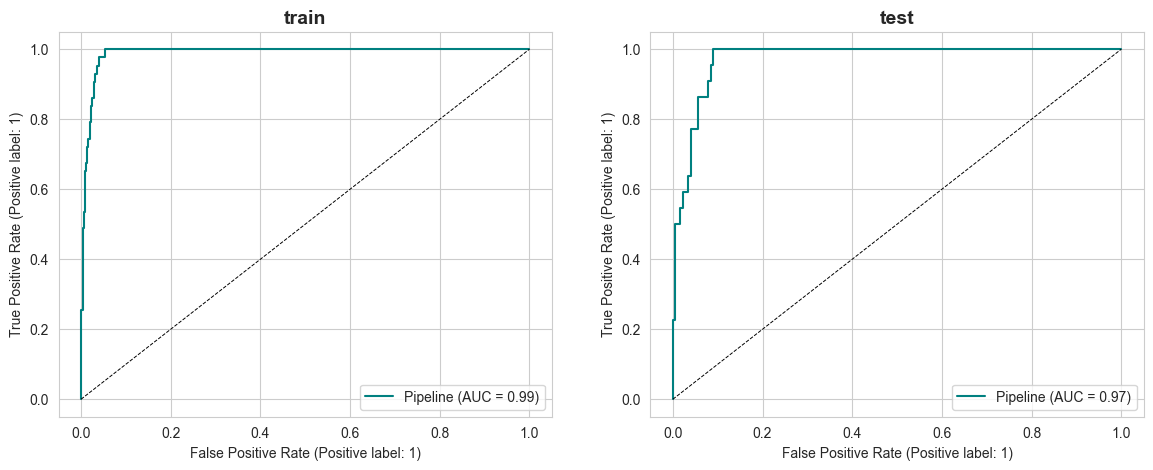

In [424]:
fig, ax = plt.subplots(1, 2, figsize=(14, 5))
ax[0].set_title("train", size=14, weight='bold')
ax[1].set_title("test", size=14, weight='bold')

RocCurveDisplay.from_estimator(log_reg_pipeline, X_train, y_train, ax=ax[0], color='teal')
ax[0].plot([0, 1], linestyle='--', color='k', linewidth=0.7)

RocCurveDisplay.from_estimator(log_reg_pipeline, X_test, y_test, ax=ax[1], color='teal')
ax[1].plot([0, 1], linestyle='--', color='k', linewidth=0.7)
;

In [430]:
print(f'Area under ROC curve for train predictions: {roc_auc_score(y_train, log_reg_pipeline.predict_proba(X_train)[ : , 1])}'
      '\n'
      f'Area under ROC curve for test predictions: {roc_auc_score(y_test, log_reg_pipeline.predict_proba(X_test)[ : , 1])}')

Area under ROC curve for train predictions: 0.9888939919001294
Area under ROC curve for test predictions: 0.9731869254341164


In [474]:
feature_names = log_reg_pipeline[:-1].get_feature_names_out()
feature_importances = list(log_reg_pipeline[1].coef_[0])

pattern = r'(.*)__(.*)'
feature_names_ok = []
for feature in feature_names:
    feature_names_ok.append(re.sub(pattern, r'\2', feature))


''

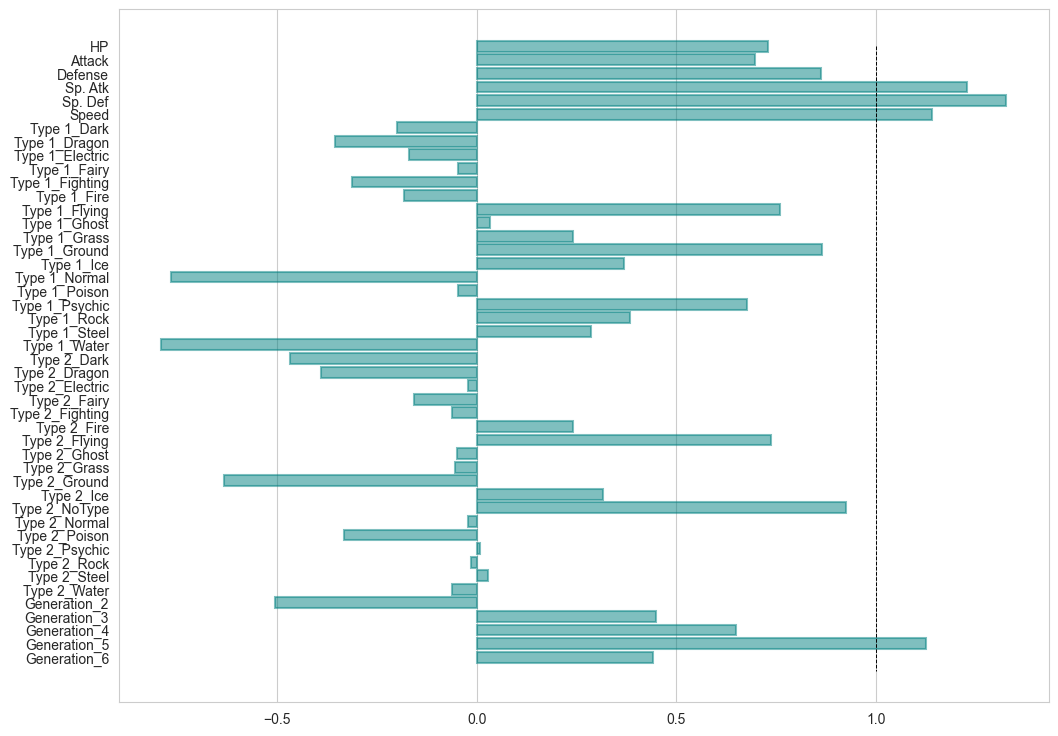

In [502]:
sns.barplot(
    x=feature_importances, y=feature_names_ok,
    linewidth=1.5, edgecolor="teal", facecolor='teal', alpha=0.5
)
plt.vlines(1, ymin=0, ymax=46, color='black', linestyle='--', linewidth=0.7)
;

The most important features for the model (above 1 or under -1):

defence, attack, speed

If a pokemon is from Generation 5, then it is a good predictor as well.

### Задание 4. Расскажите о вашей любимой музыкальной группе (исполнителе) (0.5 балла)

Расскажите, как вы познакомились с этой группой и скиньте несколько наиболее любимых треков)

My favourite band is Porcupine Tree and in general I adore the music by Steven Wilson. As one of my friends once told, "It is funny: he is our contemporary but makes a very old-fashioned music." Another friend of mine said "Why would I think he sounds like Pink Floyd? Oh well, perhaps because of 15-minute long tracks?!"

Tracks that touch my heart the most are [Arriving somewhere but not here](https://www.youtube.com/watch?v=W3lsqUqGTzM), [Buying new soul](https://www.youtube.com/watch?v=J9TsuT_AnIw) and [Time flies](https://www.youtube.com/watch?v=UkJBS0Zazmw).

Actually you can still take my advice from the previous term and listen to the album [We will always love you by The Avalances](https://www.youtube.com/playlist?list=PLfiMjLyNWxeYiTmYmJt-3WSWgxv0j8zx6) and the minimalistic concert [Music for 18 musiciand by Steve Reich](https://www.youtube.com/watch?v=ZXJWO2FQ16c&t=2783s).

## Therapy time

Напишите здесь ваши впечатления о задании: было ли интересно, было ли слишком легко или наоборот сложно и тд. Также сюда можно написать свои идеи по улучшению заданий, а также предложить данные, на основе которых вы бы хотели построить следующие дз. 

**Ваши мысли:**

And I asked myself about the present: how wide it was, how deep it was, how much was mine to keep.